In [1]:
import wandb
import random
import math
wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mariemagdalene-spreen (mariemagdalene-spreen-universit-t-osnabr-ck). Use `wandb login --relogin` to force relogin


True

### Training for self-prediction

In [14]:
sweep_config = {
    "method": "bayes" 
    }

metric = {
        "name": "val_apical_distance",
        "goal": "minimize"
        }

sweep_config["metric"] = metric

parameters_dict = {
        "lr_pi": {
            "min": 0.0004,
            "max": 0.001
            },
        "lr_ip": {
            "min": 0.0002,
            "max": 0.001
            },
        "n_samples": {
            "value": 1000
            },
        "noise": {
            "value": 0.1
            },
        "hidden_size": {
            "value": 20
            },
        "batch_size": {
            "values": [10, 30, 100]
            },
        "actfunc": {
            "value": "logexp"
            },
        "tau_weights": {
            "values": [1, 30]
            }
        }   

sweep_config["parameters"] = parameters_dict

In [15]:
sweep_id = wandb.sweep(sweep_config, project="thesis")

Create sweep with ID: mg3tlobr
Sweep URL: https://wandb.ai/mariemagdalene-spreen-universit-t-osnabr-ck/thesis/sweeps/mg3tlobr


In [17]:
import torch.optim as optim
from training_and_eval import create_dataset, self_pred_training, validate_self_pred
from netClasses import *
from tqdm import tqdm
from plotFunctions import *

T = 1000
DT = 0.1
TAU_NEU = 3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def hardsigm(x):
    return x.clamp(min=-1).clamp(max=1)

def tanh(x):
    return torch.tanh(x)

def logexp(x):
    return torch.log(1 + torch.exp(x))

def softrelu(x):
    gamma = 0.1
    beta = 1
    theta = 3
    return gamma * torch.log(1 + torch.exp(beta * (x - theta)))


def activation_function(actfunc):
    if actfunc == "logexp":
        return logexp
    elif actfunc == "hardsigm":
        return hardsigm
    elif actfunc == "tanh":
        return tanh
    elif actfunc == "softrelu":
        return softrelu


def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        rho = activation_function(config.actfunc)
        torch.manual_seed(42)
        net = dendriticNet(
            DT,
            size_tab=[30, config.hidden_size, 10],
            lr_pf=[0, 0],
            lr_ip=[config.lr_ip],
            lr_pi=[config.lr_pi],
            lr_pb=[0],
            ga=0.8,
            gb=1,
            gd=1,
            glk=0.1,
            gsom=0.8,
            noise=config.noise,
            tau_weights=config.tau_weights,
            rho=rho,
            initw=1,
            device=DEVICE
        )
        torch.manual_seed(42)
        data = create_dataset(config.n_samples, config.batch_size, 30, 0, 1, DEVICE)  
        val_data = create_dataset(5, 100, 30, 0, 1, DEVICE)
        net.to(DEVICE)
        net.train()
        with torch.no_grad():
            data_trace = data[0].clone()
            va_topdown_hist=[]
            va_cancelation_hist=[]
            apical_dist = 0
            pyr_int_dist = 0
            for n in tqdm(range(data.shape[0])):
                for k in range(T):
                    # low-pass filter the data
                    data_trace += (DT / TAU_NEU) * (-data_trace + data[n])
                    va = net.stepper(data_trace)
                    # Track apical potential, neurons and synapses
                    if k == 500 and n % 20 == 0:
                        va_topdown, va_cancelation, vb_input = va
                        # Update the tabs with the current values
                        va_topdown_hist = net.updateHist(va_topdown_hist, va_topdown)
                        va_cancelation_hist = net.updateHist(
                            va_cancelation_hist, va_cancelation
                        )
                    # Update the pyramidal-to-interneuron weights (NOT the pyramidal-to-pyramidal weights !)
                    net.updateWeights(data[n])
                if n%100 == 0:
                    api_dist, p_i_dist = validate_self_pred(net, val_data, T, DT, TAU_NEU, DEVICE)
                    apical_dist = api_dist[0]
                    pyr_int_dist = p_i_dist[0]
                apical_distance = (
                    ((va_topdown[0] + va_cancelation[0]) ** 2)
                    .cpu()
                    .numpy()
                    .sum(1)
                    .mean(0)
                )
                val_apical_dist = apical_dist
                val_pyr_int_dist = pyr_int_dist
                wandb.log(
                    {
                        "apical_distance": apical_distance,
                        "val_apical_distance": val_apical_dist,
                        "val_pyr_int_distance": val_pyr_int_dist
                    }
                )
        # save the weights in a file named after the wandb run
        net.save_weights(wandb.run.name)

##### run the sweep

In [18]:
wandb.agent(sweep_id, train, count=50)

wandb: Agent Starting Run: yx3tvgyo with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 100
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.00046211874174398673
wandb: 	lr_pi: 0.0009616665401316392
wandb: 	n_samples: 1000
wandb: 	noise: 0.1
wandb: 	tau_weights: 30
wandb: Ctrl + C detected. Stopping sweep.


  0%|          | 4/1000 [00:04<16:43,  1.01s/it]Traceback (most recent call last):
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/tqdm/std.py", line 1191, in __iter__
    self.update(n - last_print_n)
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/tqdm/std.py", line 1242, in update
    self.refresh(lock_args=self.lock_args)
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/tqdm/std.py", line 1495, in display
    self.sp(self.__str__() if msg is None else msg)
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/tqdm/std.p

### Training on one target

##### config

In [6]:
sweep_config = {
    "method": "bayes"
    }

metric = {
        "name": "val_error",
        "goal": "minimize"
        }

sweep_config["metric"] = metric

parameters_dict = {
        "lr_pf_0": {
            # "values": [0.0005, 0.0011875, 0.0015]
            # "value": 0.0009 # 0.0011875
            "min": 0.0005,
            "max": 0.0015
            },
        "lr_pf_1": {
            # "values": [0.0001, 0.0005, 0.001]
            # "value": 0.0009 # 0.0005
            "min": 0.0001,
            "max": 0.001
            },
        "lr_pi": {
            # "values": [0.0001, 0.0005, 0.001]
            # "value": 0.0005 # 0.0005
            "min": 0.0001,
            "max": 0.001
            },
        "lr_ip": {
            # "values": [0.0005, 0.0011875, 0.0015]
            # "value": 0.0015 # 0.0011875
            "min": 0.0005,
            "max": 0.0015
            },
        "n_samples": {
            "value": 1,
            },
        "noise": {
            "value": 0.1
            },
        "hidden_size": {
            "value": 20
            },
        "batch_size": {
            "value": 1
            },
        "actfunc": {
            "value": "logexp"
            },
        "tau_weights": {
            "values": [1, 10, 20, 30]
            },
        "weight_run": {
            "values": [3, 4]
            },
        "n_steps": {
            # "values": [15, 50, 100]
            "value": 500
            }
        }   

sweep_config["parameters"] = parameters_dict

In [7]:
sweep_id = wandb.sweep(sweep_config, project="thesis-one-target")

Create sweep with ID: w40ovcia
Sweep URL: https://wandb.ai/mariemagdalene-spreen-universit-t-osnabr-ck/thesis-one-target/sweeps/w40ovcia


##### training

In [8]:
import torch.optim as optim
from training_and_eval import create_dataset, self_pred_training, evalrun
from netClasses import *
from tqdm import tqdm
from plotFunctions import *
from config import *

def hardsigm(x):
    return x.clamp(min=-1).clamp(max=1)

def tanh(x):
    return torch.tanh(x)

def logexp(x):
    return torch.log(1 + torch.exp(x))

def softrelu(x):
    gamma = 0.1
    beta = 1
    theta = 3
    return gamma * torch.log(1 + torch.exp(beta * (x - theta)))


def activation_function(actfunc):
    if actfunc == "logexp":
        return logexp
    elif actfunc == "hardsigm":
        return hardsigm
    elif actfunc == "tanh":
        return tanh
    elif actfunc == "softrelu":
        return softrelu


def train(config=None):
    with wandb.init(config=config):
        sample_range = [-1, 1]
        if wandb.config.weight_run == 3:
            weight_path = "runs/2025-01-22/run_3/weights_selfpred_10000eps.pt"
        else:
            weight_path = "runs/2025-01-22/run_4/weights_selfpred_10000eps.pt"
            sample_range = [0, 1]
        config = Config(
            name = "single_target",
            n_samples=wandb.config.n_samples,
            batch_size=wandb.config.batch_size,
            dt=0.1,
            t=1000,
            tau_neu=3,
            size_tab=[30, wandb.config.hidden_size, 10],
            lr_pf = [wandb.config.lr_pf_0, wandb.config.lr_pf_1],
            lr_ip = [wandb.config.lr_ip],
            lr_pi = [wandb.config.lr_pi],
            lr_pb = [0],
            ga = 0.8,
            gb = 1,
            gd = 1,
            glk = 0.1,
            gsom = 0.8,
            noise = 0.1,
            tau_weights = wandb.config.tau_weights,
            rho = activation_function(wandb.config.actfunc),
            initw = 1,
            device = "cpu",
            sample_range = sample_range
        )
        net = dendriticNet(config)
        net.load_weights(weight_path)
        data = torch.FloatTensor(1, 30, device=config.device).uniform_(config.sample_range[0], config.sample_range[1])
        rand_target = torch.FloatTensor(1, 10, device=config.device).uniform_(config.sample_range[0], config.sample_range[1])
        fig_data = [data, data]
        fig_target = [None, rand_target]
        net.to(config.device)
        net.train()
        with torch.no_grad():
            (data_hist, den_in_hist, target_hist, s_hist) = evalrun(
                net, fig_data, fig_target, config
            )
            title = "pre-learning_single_target"
            plot_apical_trace(
                title,
                5,
                net.depth + 1,
                data_hist,
                den_in_hist,
                target_hist,
                s_hist,
                run_number=wandb.run.id
            )
            data_trace = data.clone()
            va_topdown_hist=[]
            va_cancelation_hist=[]
            s_hist=[]
            for n in tqdm(range(wandb.config.n_steps)):
                if n == 0:
                    target = None
                else:
                    target = rand_target
                for k in range(config.t):
                    # low-pass filter the data
                    data_trace += (config.dt / config.tau_neu) * (-data_trace + data)
                    va = net.stepper(data_trace, target)
                    # Track apical potential, neurons and synapses
                    if k % 100 == 0:
                        va_topdown, va_cancelation, vb_input = va
                        # Update the tabs with the current values
                        va_topdown_hist = net.updateHist(va_topdown_hist, va_topdown)
                        va_cancelation_hist = net.updateHist(
                            va_cancelation_hist, va_cancelation
                        )
                    # Update the pyramidal-to-interneuron weights (NOT the pyramidal-to-pyramidal weights !)
                    net.updateWeights(data)
                api_dist = (
                    ((va_topdown[0] + va_cancelation[0]) ** 2)
                    .cpu()
                    .numpy()
                    .sum(1)
                    .mean(0)
                )
                if target is not None:
                    val_error = ((target - net.u_p[-1]) ** 2).cpu().numpy().sum(1).mean(0)
                else:
                    val_error = None
                pyr_int_dist = ((net.u_p[-1] - net.u_i[-1]) ** 2).cpu().numpy().sum(1).mean(0)
                wandb.log(
                    {
                        "apical_distance": api_dist,
                        "pyr_int_distance": pyr_int_dist,
                        "val_error": val_error
                    }
                )
                
            # save the weights in a file named after the wandb run
            net.save_weights(wandb.run.name)

            (data_hist, den_in_hist, target_hist, s_hist) = evalrun(
                net, fig_data, fig_target, config
                )
            title = "post-learning_single_target({}steps)".format(n+1)
            plot_apical_trace(
                title,
                5,
                net.depth + 1,
                data_hist,
                den_in_hist,
                target_hist,
                s_hist,
                run_number=wandb.run.id
            )

        

##### run the sweep

wandb: Agent Starting Run: hlvaeaez with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 1
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.0006006362729082575
wandb: 	lr_pf_0: 0.0005914727960434549
wandb: 	lr_pf_1: 0.0008851436587317673
wandb: 	lr_pi: 0.0005976704618198336
wandb: 	n_samples: 1
wandb: 	n_steps: 500
wandb: 	noise: 0.1
wandb: 	tau_weights: 20
wandb: 	weight_run: 3


1000
evalrun, sample 1
evalrun, sample 2


100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

1000
evalrun, sample 1
nan found
va_topdown:  [tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])]
va_cancelation:  [tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])]
vb_input:  [tensor([[ 0.4435, -0.6529,  0.4279,  1.2981,  0.0953,  0.4411, -0.0917,  1.0887,
          0.3350,  0.0064,  0.0595,  1.2484, -0.4623, -0.6967, -1.0066,  0.0158,
         -0.0661,  1.4259,  0.0366,  0.3151]]), tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])]
data_trace:  tensor([[-0.2013,  0.2256, -0.4616,  0.0022, -0.6465,  0.1642, -0.3040, -0.0418,
          0.3559, -0.6633,  0.5388, -0.9517,  0.0642,  0.0707, -0.4075, -0.9166,
         -0.8486, -0.2375,  0.0991,  0.2203, -0.9556,  0.1931, -0.4793, -0.7471,
          0.8370, -0.6707,  0.1120,  0.3051,  0.2168,  0.4779]])
batch:  tensor([[-0.2013,  0.2256, -0.4616,  0.0022, -0.6465,  0.1642, -0.3040, -0.0418,
          0.3559,


Traceback (most recent call last):
  File "/tmp/ipykernel_120256/1696037601.py", line 136, in train
    (data_hist, den_in_hist, target_hist, s_hist) = evalrun(
                                                    ^^^^^^^^
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/training_and_eval.py", line 50, in evalrun
    raise ValueError("nan found")
ValueError: nan found


apical_distance,█▇▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pyr_int_distance,█▆▇▆▅▄▄▄▄▃▄▄▄▃▄▄▃▂▃▂▃▃▃▃▃▂▂▃▂▂▂▁▂▂▁▂▁▂▁▂
val_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇█
apical_distance,0.06908
pyr_int_distance,0.67429
val_error,40.03629


Run hlvaeaez errored:
Traceback (most recent call last):
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_120256/1696037601.py", line 136, in train
    (data_hist, den_in_hist, target_hist, s_hist) = evalrun(
                                                    ^^^^^^^^
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/training_and_eval.py", line 50, in evalrun
    raise ValueError("nan found")
ValueError: nan found

wandb: ERROR Run hlvaeaez errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_120256/1696037601.py", line 136, in tr

1000
evalrun, sample 1
evalrun, sample 2


100%|██████████| 500/500 [04:12<00:00,  1.98it/s]

1000
evalrun, sample 1
nan found
va_topdown:  [tensor([[inf, nan, nan, nan, -inf, inf, nan, nan, inf, inf, inf, inf, -inf, -inf, -inf, nan, inf, inf, nan, nan]])]
va_cancelation:  [tensor([[ -54.9790,   77.1241,   50.0036,  -29.9531,   65.9325,  -23.8776,
           -6.3619,  -19.4974, -139.0978,  -87.5599, -163.5675, -152.7282,
           74.9173,  110.0412,   50.6349,   -2.9534,  -65.0846,  -76.4478,
           54.4744,   14.7054]])]
vb_input:  [tensor([[ 0.6386, -0.4798, -0.0064,  1.4618,  0.5385,  0.4369, -0.0810,  2.1342,
         -0.1510,  0.3067,  0.6166,  2.5964, -0.1230, -0.4545, -1.2813,  0.1416,
          0.0871,  1.3901, -0.2257, -0.4873]]), tensor([[317.4157, 199.3530,  -6.8873, 124.2129, 312.7664, -21.5673, -11.9021,
          95.7954, -22.3222, 142.1175]])]
data_trace:  tensor([[-0.7825, -0.1381,  0.0522,  0.7437, -0.8497,  0.1703, -0.8152, -0.2963,
         -0.5298,  0.8759,  0.1513,  0.9705,  0.0461, -0.9708, -0.9638,  0.8497,
         -0.2257,  0.4232, -0.1505,  0.019


Traceback (most recent call last):
  File "/tmp/ipykernel_120256/1696037601.py", line 136, in train
    (data_hist, den_in_hist, target_hist, s_hist) = evalrun(
                                                    ^^^^^^^^
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/training_and_eval.py", line 50, in evalrun
    raise ValueError("nan found")
ValueError: nan found


apical_distance,█▂▄▂▃▃▂▁▂▂▂▂▁▁▃▃▂▂▂▃▃▂▃▁▁▁▂▁▁▂▁▁▂▁▁▃▂▁▃▃
pyr_int_distance,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_error,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▇▇█
apical_distance,0.01248
pyr_int_distance,0.02264
val_error,3161.06592


Run 14agra3o errored:
Traceback (most recent call last):
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_120256/1696037601.py", line 136, in train
    (data_hist, den_in_hist, target_hist, s_hist) = evalrun(
                                                    ^^^^^^^^
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/training_and_eval.py", line 50, in evalrun
    raise ValueError("nan found")
ValueError: nan found

wandb: ERROR Run 14agra3o errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_120256/1696037601.py", line 136, in tr

1000
evalrun, sample 1
evalrun, sample 2


100%|██████████| 500/500 [04:12<00:00,  1.98it/s]

1000
evalrun, sample 1
nan found
va_topdown:  [tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])]
va_cancelation:  [tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])]
vb_input:  [tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]), tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])]
data_trace:  tensor([[ 0.6754, -0.6140, -0.7819,  0.9453, -0.2376,  0.4784,  0.7233,  0.2108,
          0.6845, -0.2817,  0.7336,  0.6074, -0.4427,  0.1465, -0.1808,  0.7901,
         -0.3327, -0.3952, -0.5244, -0.1802, -0.5162,  0.9843,  0.3389, -0.1948,
          0.3760,  0.5539,  0.0990, -0.4290,  0.6990, -0.1055]])
batch:  tensor([[ 0.6754, -0.6140, -0.7819,  0.9453, -0.2376,  0.4784,  0.7233,  0.2108,
          0.6845, -0.2817,  0.7336,  0.6074, -0.4427,  0.1465, -0.1808,  0.7901,
         -0.3327, -0.3952, -0.5244


Traceback (most recent call last):
  File "/tmp/ipykernel_120256/1696037601.py", line 136, in train
    (data_hist, den_in_hist, target_hist, s_hist) = evalrun(
                                                    ^^^^^^^^
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/training_and_eval.py", line 50, in evalrun
    raise ValueError("nan found")
ValueError: nan found


apical_distance,▁▁▂▂▃▄▆█▆▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pyr_int_distance,▁▁▁▁▂▇▇█████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_error,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇███


Run m7o8058m errored:
Traceback (most recent call last):
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_120256/1696037601.py", line 136, in train
    (data_hist, den_in_hist, target_hist, s_hist) = evalrun(
                                                    ^^^^^^^^
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/training_and_eval.py", line 50, in evalrun
    raise ValueError("nan found")
ValueError: nan found

wandb: ERROR Run m7o8058m errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_120256/1696037601.py", line 136, in tr

1000
evalrun, sample 1
evalrun, sample 2


100%|██████████| 500/500 [04:06<00:00,  2.03it/s]


1000
evalrun, sample 1
evalrun, sample 2


apical_distance,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pyr_int_distance,▁█▆▆▆▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▇▇▇█
apical_distance,0.04049
pyr_int_distance,0.2348
val_error,77.01573


wandb: Agent Starting Run: ncfsu5pf with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 1
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.0014138367294964883
wandb: 	lr_pf_0: 0.0007998706574210586
wandb: 	lr_pf_1: 0.000894952251655302
wandb: 	lr_pi: 0.000652659172435964
wandb: 	n_samples: 1
wandb: 	n_steps: 500
wandb: 	noise: 0.1
wandb: 	tau_weights: 20
wandb: 	weight_run: 4


1000
evalrun, sample 1
evalrun, sample 2


100%|██████████| 500/500 [04:15<00:00,  1.96it/s]

1000
evalrun, sample 1
nan found
va_topdown:  [tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])]
va_cancelation:  [tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])]
vb_input:  [tensor([[ 0.5378, -0.9523,  1.0309,  1.9011,  0.6026,  2.2428, -0.5223,  1.6541,
         -0.1380, -0.3183, -0.1743,  1.9539, -0.8052, -1.0043, -1.0639, -0.0709,
         -0.5475,  3.5222, -0.0404,  1.1917]]), tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])]
data_trace:  tensor([[0.6863, 0.6732, 0.6206, 0.5395, 0.9577, 0.0718, 0.9935, 0.6377, 0.9729,
         0.9227, 0.2620, 0.4729, 0.1835, 0.0957, 0.3361, 0.6222, 0.7920, 0.9311,
         0.0226, 0.2100, 0.1670, 0.1348, 0.6472, 0.4270, 0.0832, 0.7867, 0.9849,
         0.0996, 0.5546, 0.9034]])
batch:  tensor([[0.6863, 0.6732, 0.6206, 0.5395, 0.9577, 0.0718, 0.9935, 0.6377, 0.9729,
         0.9227, 0.2620, 0.4729, 0.1835, 0.0957


Traceback (most recent call last):
  File "/tmp/ipykernel_120256/1696037601.py", line 136, in train
    (data_hist, den_in_hist, target_hist, s_hist) = evalrun(
                                                    ^^^^^^^^
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/training_and_eval.py", line 50, in evalrun
    raise ValueError("nan found")
ValueError: nan found


apical_distance,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pyr_int_distance,█▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_error,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▄▄▄▄▄▄▄▄▄▄▄▅▆▆▆▇▇▇▇▇█
apical_distance,0.08048
pyr_int_distance,0.10479
val_error,158.8568


Run ncfsu5pf errored:
Traceback (most recent call last):
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_120256/1696037601.py", line 136, in train
    (data_hist, den_in_hist, target_hist, s_hist) = evalrun(
                                                    ^^^^^^^^
  File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/training_and_eval.py", line 50, in evalrun
    raise ValueError("nan found")
ValueError: nan found

wandb: ERROR Run ncfsu5pf errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_120256/1696037601.py", line 136, in tr

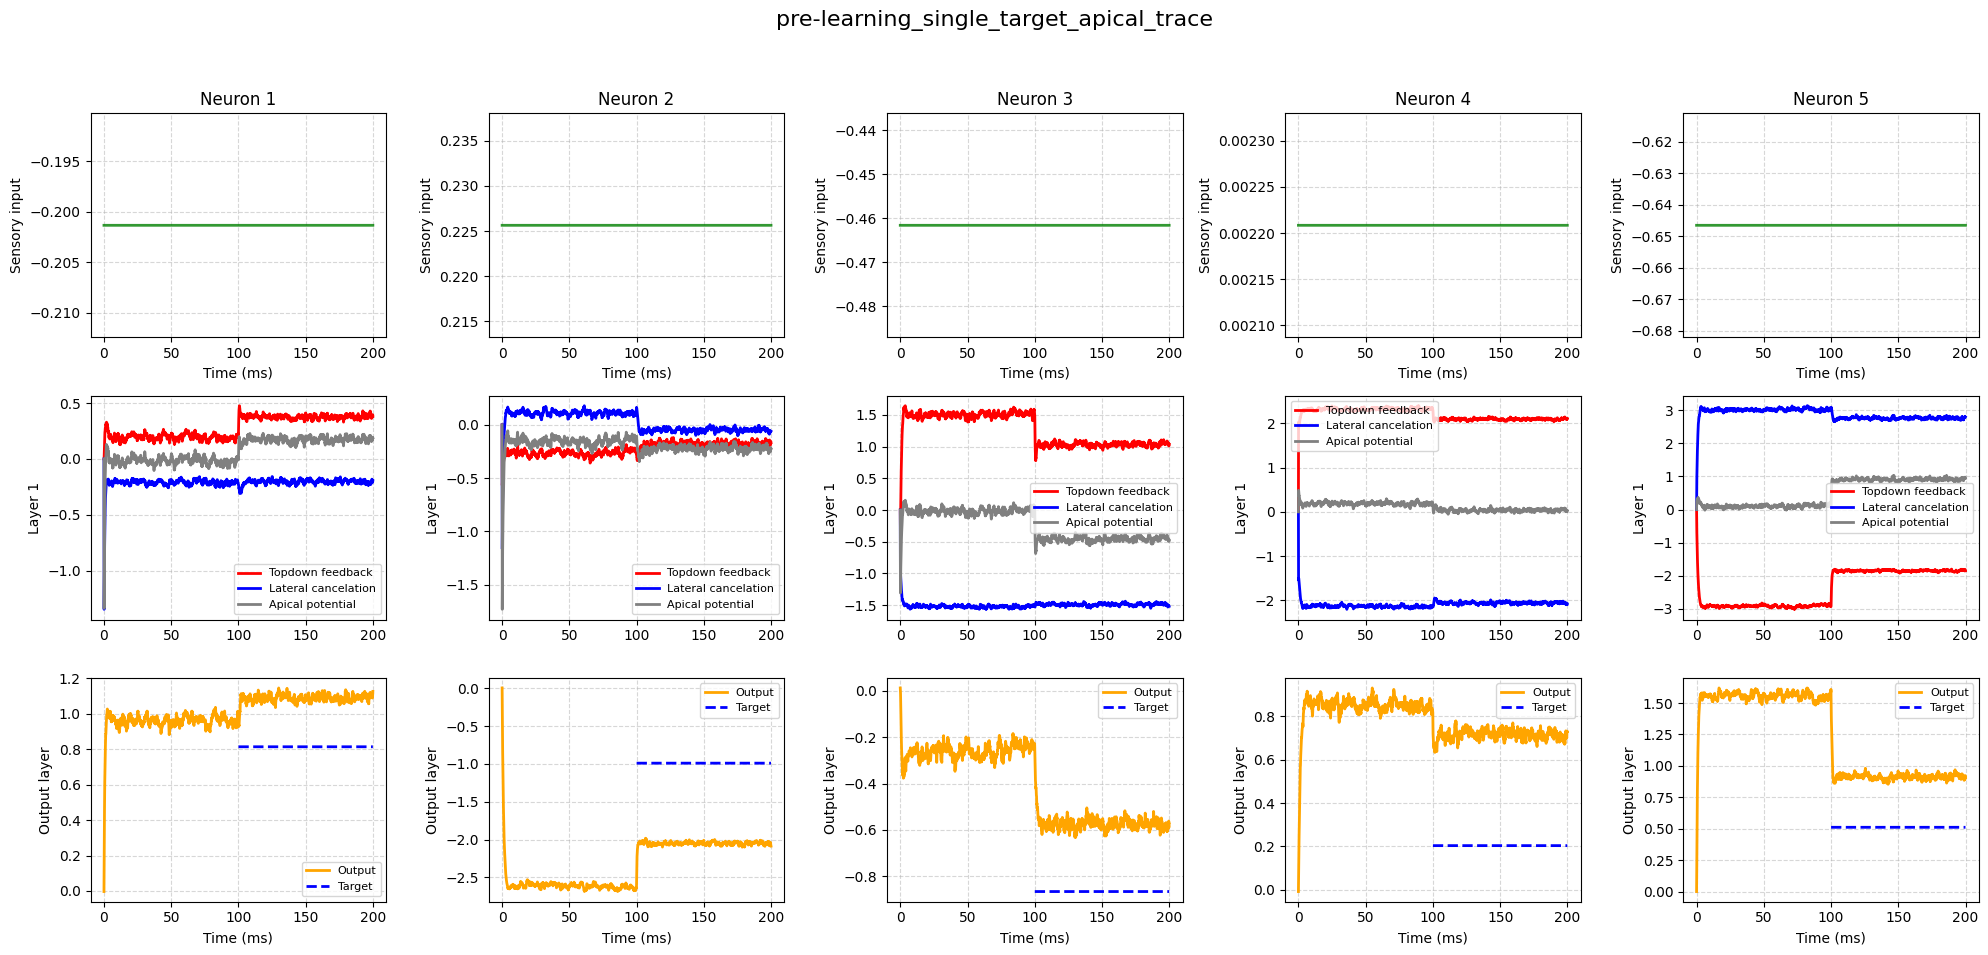

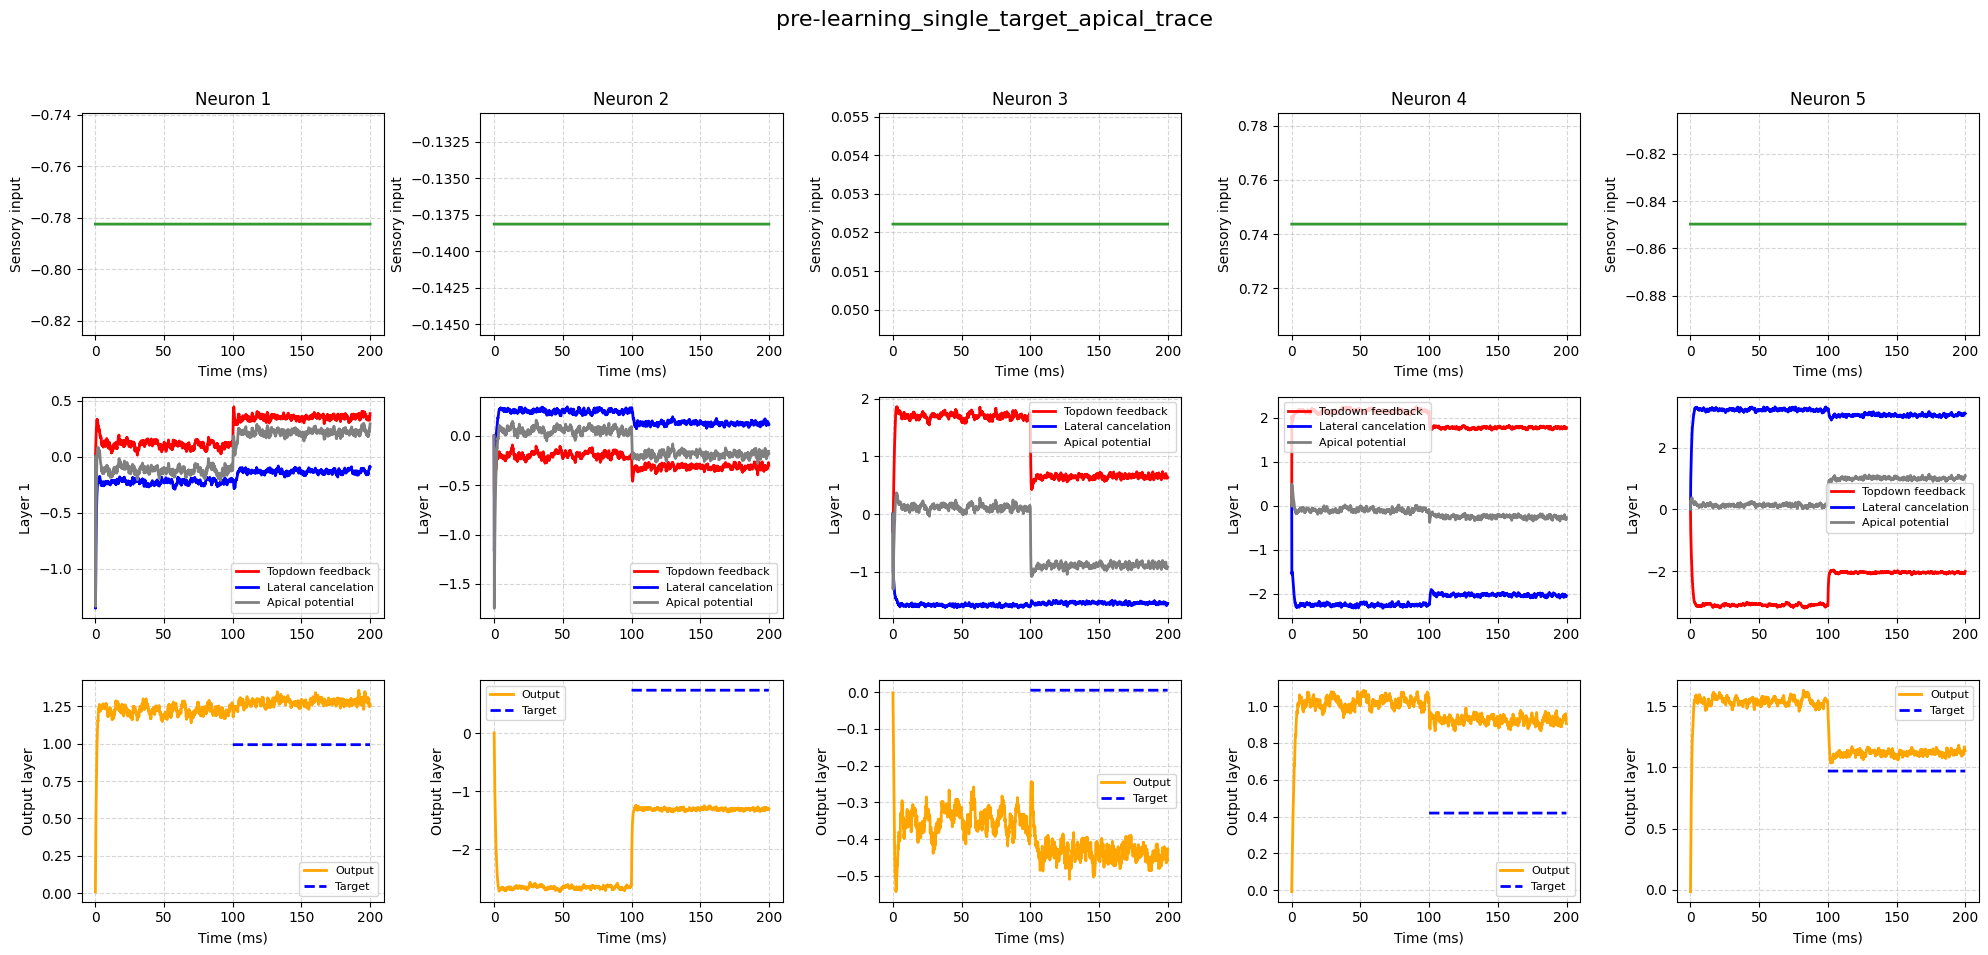

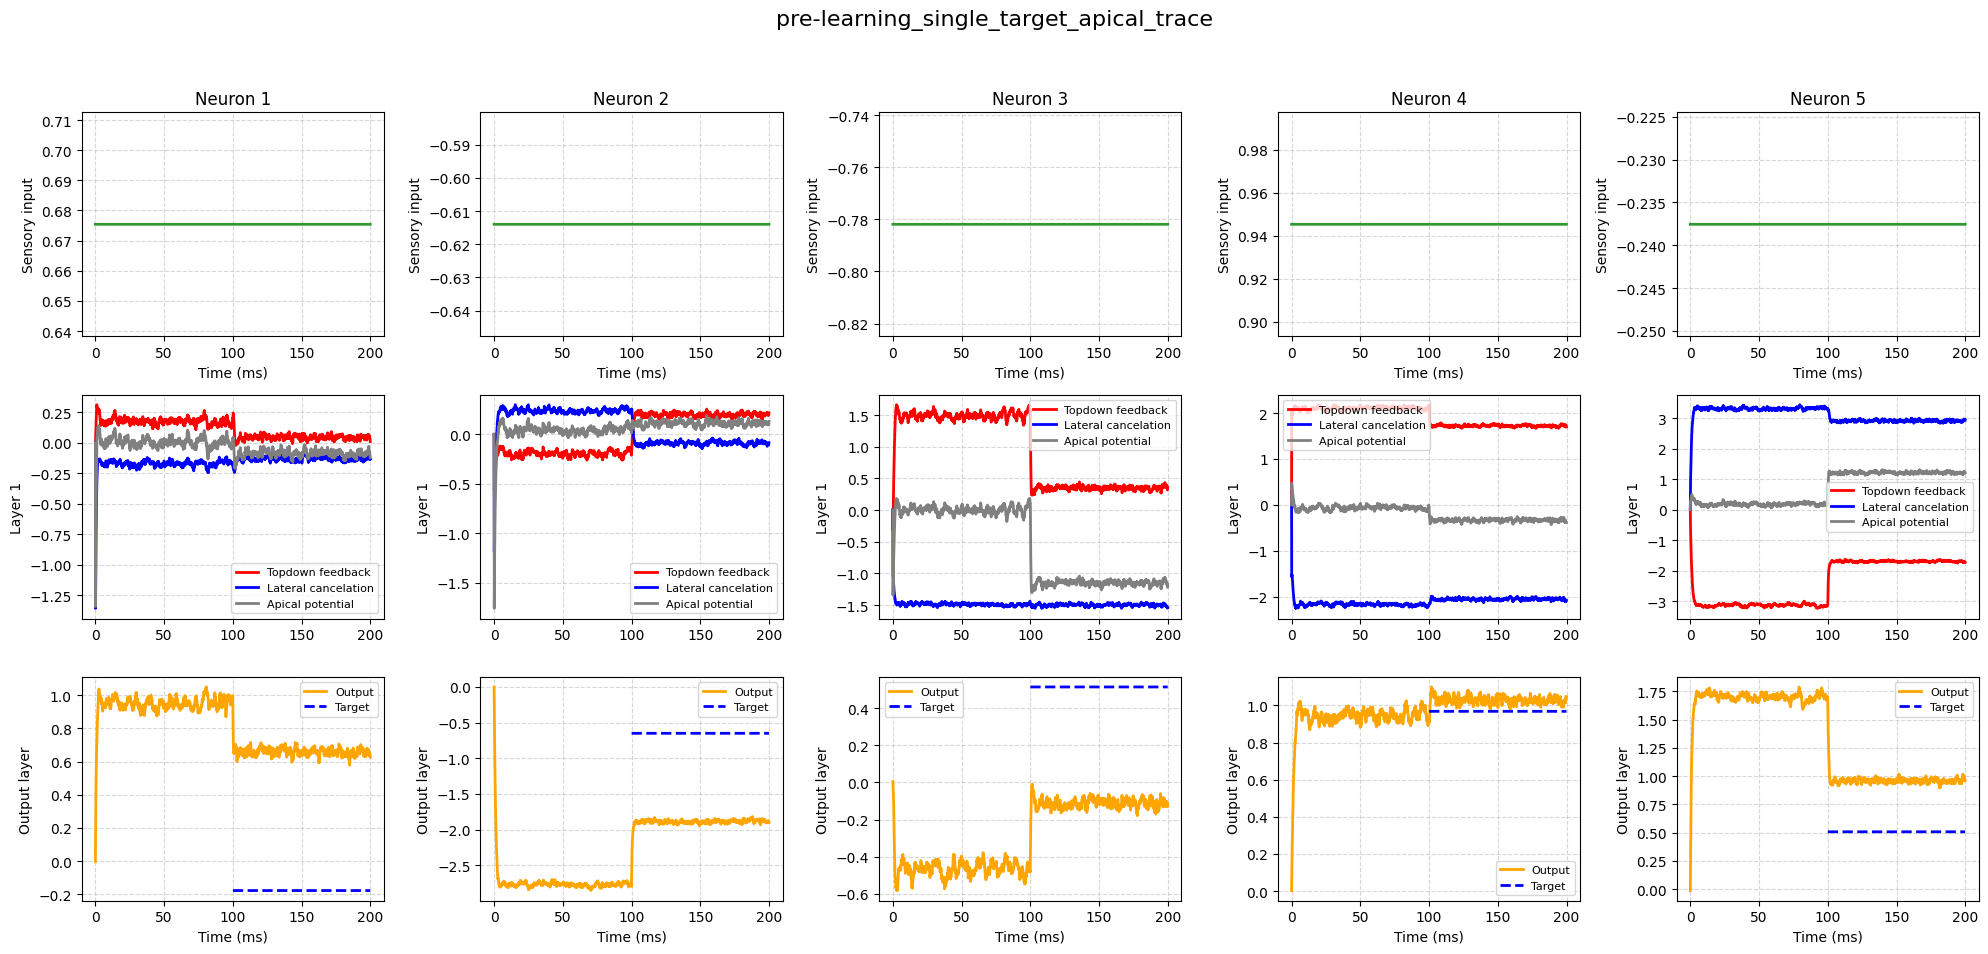

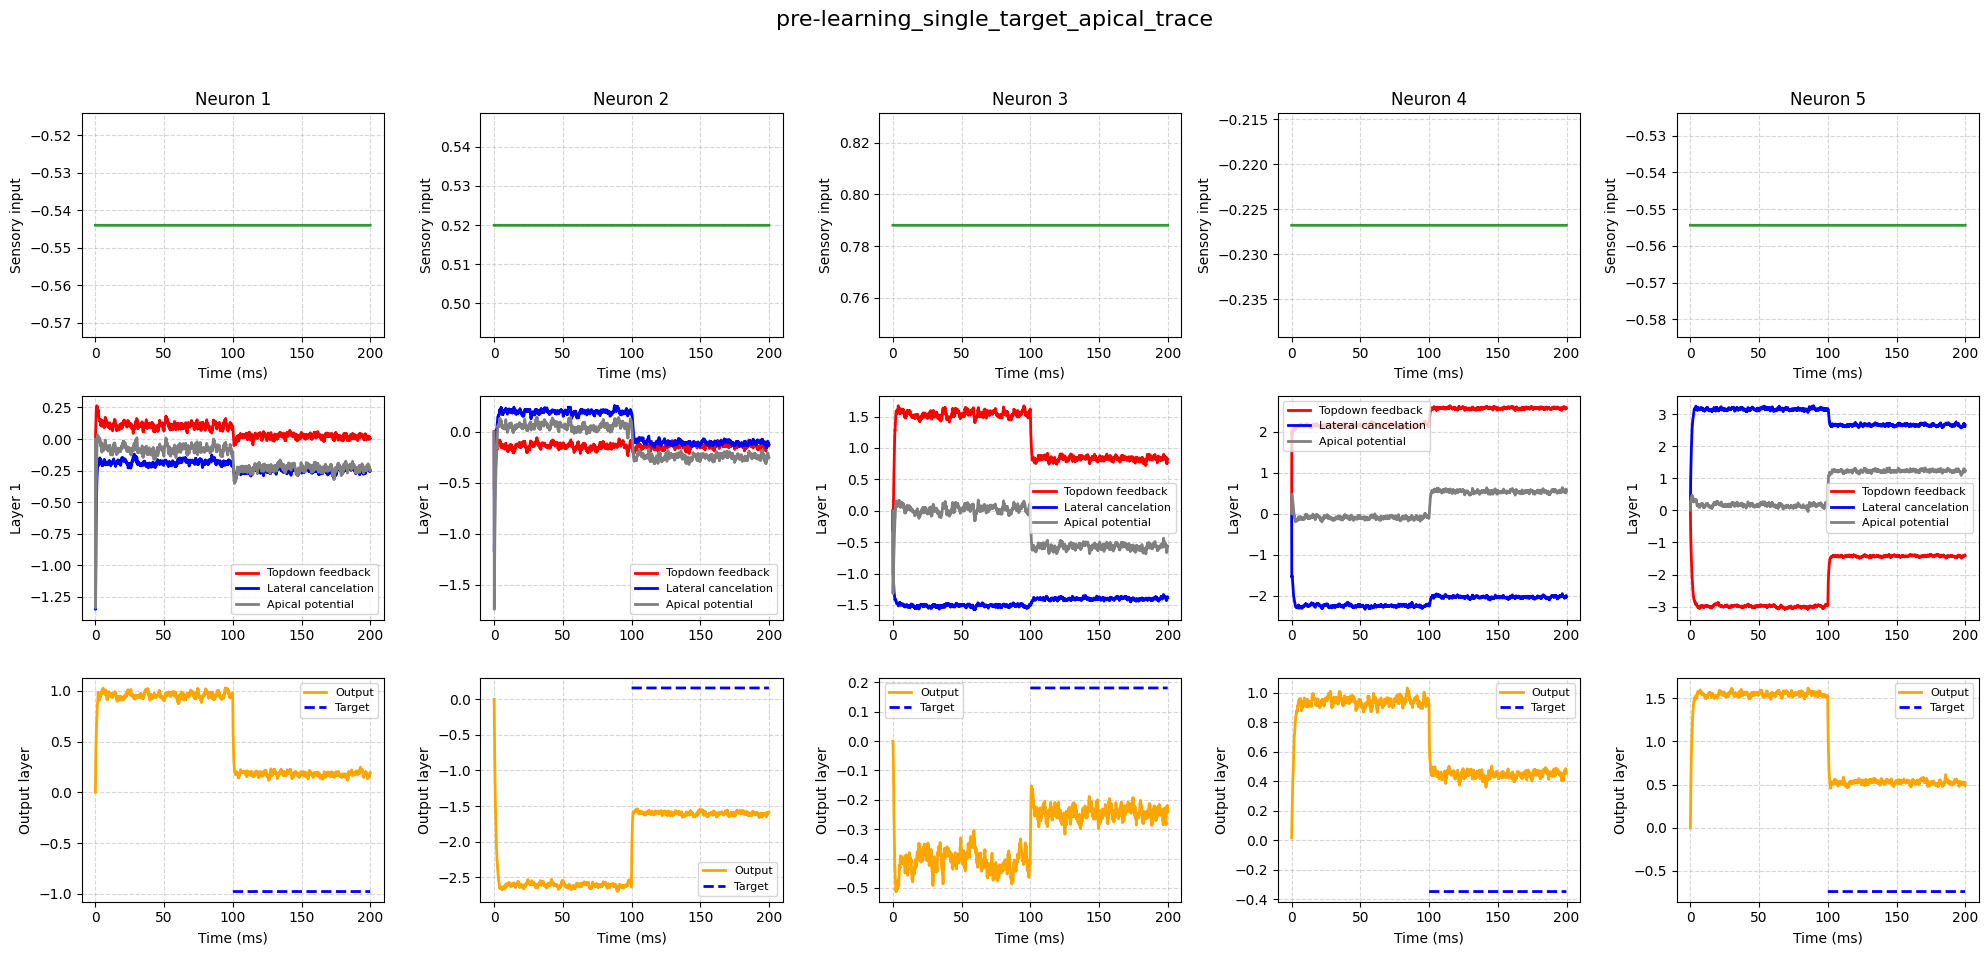

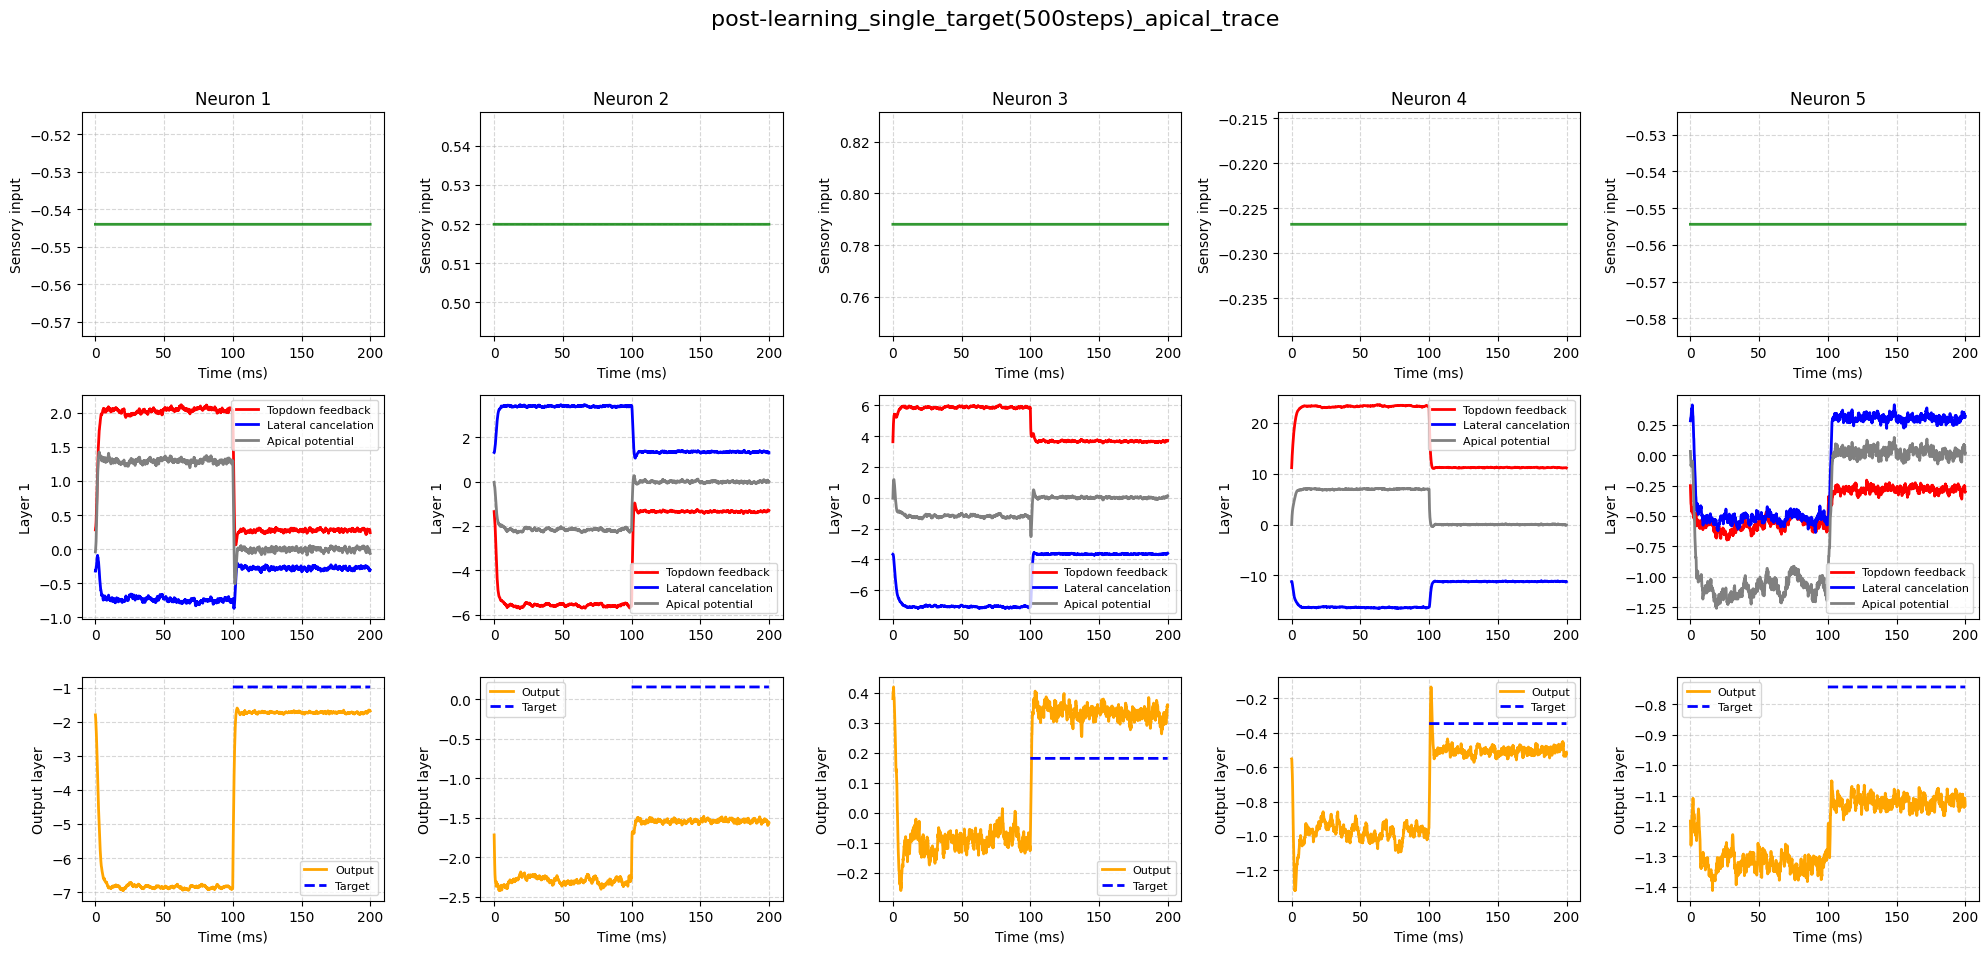

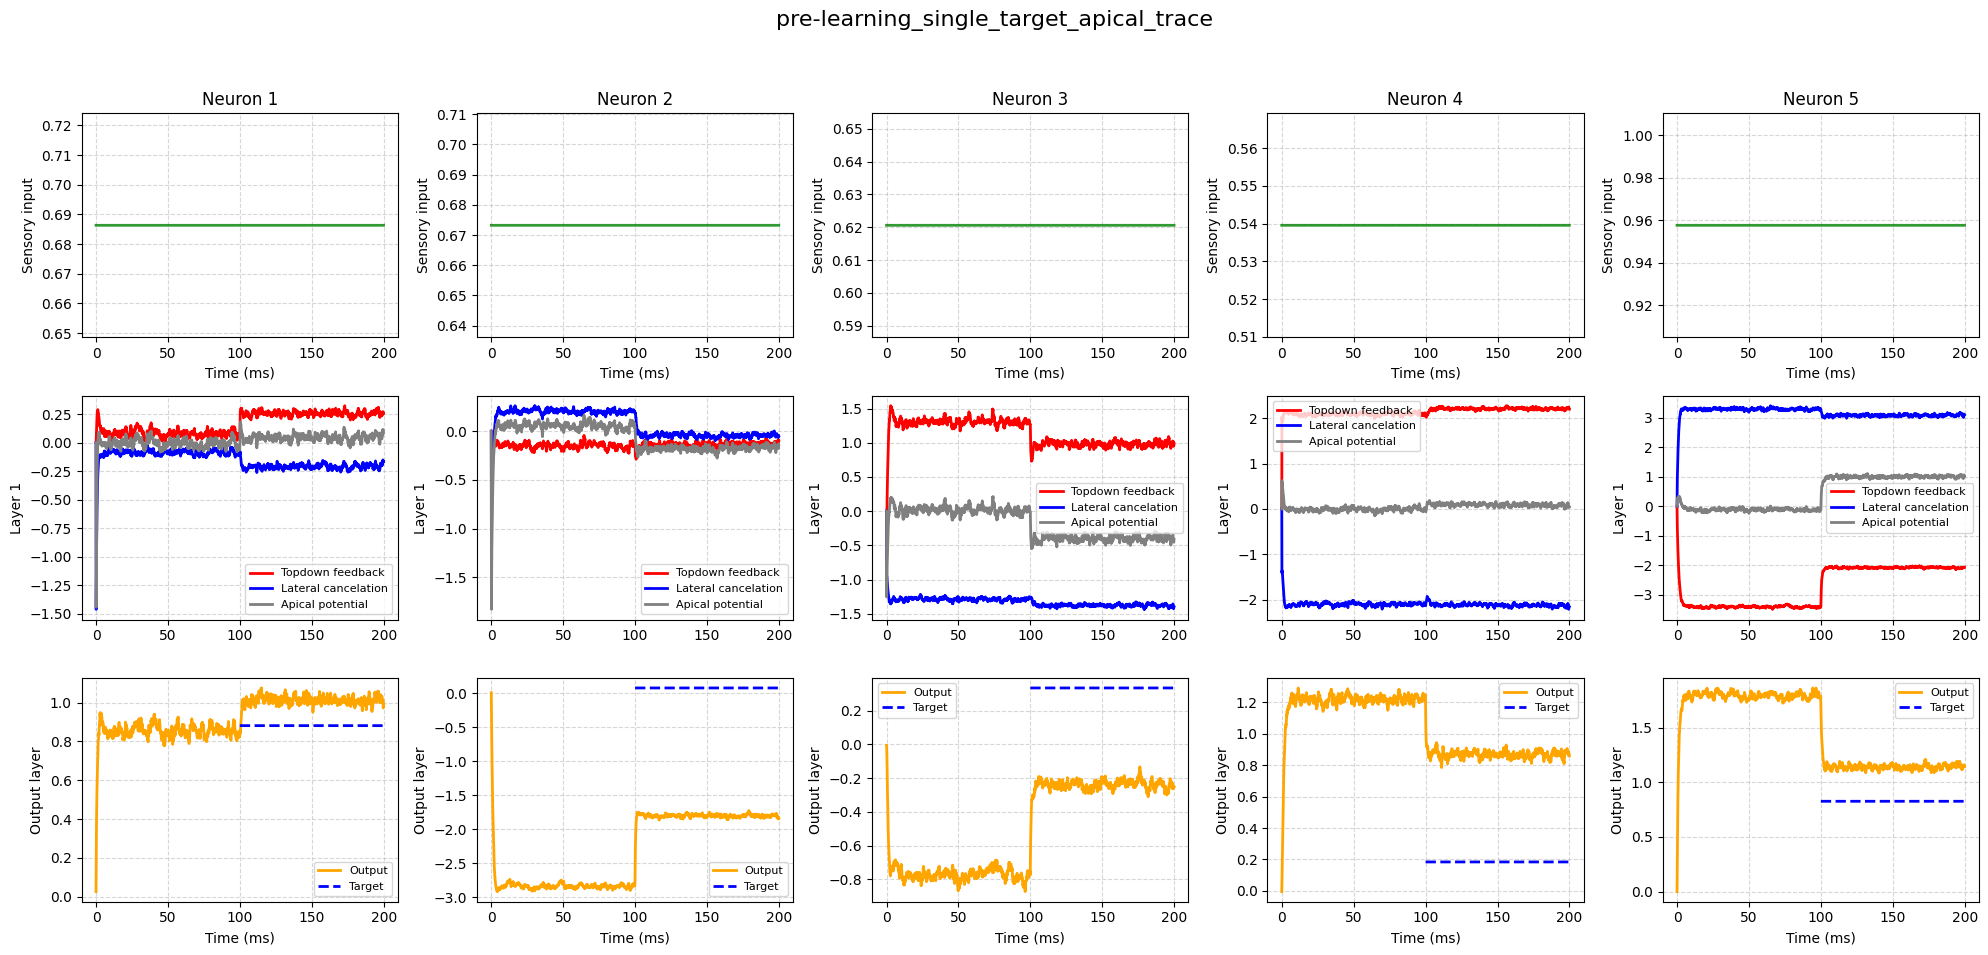

In [9]:
wandb.agent(sweep_id, train, count=5)